In [3]:
import torch
import torch.nn as nn        # Pytorch neural network package
import torch.optim as optim  # Pytorch optimization package
import torch.nn.functional as F
import numpy
import numpy as np
import matplotlib.pyplot as plt
from torchtyping import TensorType


device = torch.device("cuda")

In [4]:
class Encoder(nn.Module):
    def __init__(self, output_dim: int, num_channels: int, latent_dim: int):
        super(Encoder, self).__init__()
        self.output_dim = output_dim
        self.num_channels = num_channels

        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=4, stride=2, padding=1)  # 42 x 42
        self.conv2 = nn.Conv2d(32, 32, 2, 2, 1)  # 21 x 21
        self.conv3 = nn.Conv2d(32, 64, 2, 2, 1)  # 11 x 11
        self.conv4 = nn.Conv2d(64, 64, 2, 2, 1)  # 6 x 6
        self.flat1 = nn.Flatten()
        self.dense1 = nn.Linear(3136, 256) # 6x6x 64 = 2304
        self.dense_means_logVar = nn.Linear(256, latent_dim*2)
        #self.dense_log_var = nn.Linear(256, latent_dim)

        self.act = nn.ReLU(inplace=True)
    
    
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
    
    
    def forward(self, x: TensorType["batch", "num_channels", "x", "y"]
                ) -> (TensorType["batch", "output_dim"], TensorType["batch", "output_dim"]):
        #print("encoder: ")
        #print(x.size())
        h = self.act(self.conv1(x))
        #print("conv1: " + str(h.size()))
        h = self.act(self.conv2(h))
        #print("conv2: " + str(h.size()))
        h = self.act(self.conv3(h))
        #print("conv3: " + str(h.size()))
        h = self.act(self.conv4(h))
        #print("conv4: " + str(h.size()))
        
        h = self.flat1(h)
        #print(h.size())
        h = self.act(self.dense1(h))
        #print(h.size())
        #means = self.dense_means(h)
        #print(means.size())
        #log_var = self.dense_log_var(h)
        #print(log_var.size())
        return self.dense_means_logVar(h)
        
        #sample = self.reparameterize(means, log_var)
        
        #return sample, means, log_var
        #return means, log_var


In [5]:
class Decoder(nn.Module):
    def __init__(self, input_dim: int, num_channels: int, latent_dim: int):
        super(Decoder, self).__init__()
        self.input_dim = input_dim
        self.num_channels = num_channels

        self.dense1 = nn.Linear(latent_dim, 256)
        self.dense2 = nn.Linear(256, 3136)

        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(64, 32, 2, stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(32, 32, 2, stride=2, padding=1)
        self.upconv4 = nn.ConvTranspose2d(32, num_channels, 4, stride=2, padding=1)

        self.act = nn.ReLU(inplace=True)
        

    def forward(self, z: TensorType["batch", "input_dim"]
                ) -> TensorType["batch", "num_channels", "x", "y"]:
        #print("decoder: ")
        h = self.act(self.dense1(z))
        h = self.act(self.dense2(h))
        h = h.view(-1, 64, 7, 7)
        #print(h.size())
        h = self.act(self.upconv1(h))
        #print("Transpose 1: " + str(h.size()))
        h = self.act(self.upconv2(h))
        #print("Transpose 2: " + str(h.size()))
        h = self.act(self.upconv3(h))
        #print("Transpose 3: " + str(h.size()))
        img = self.upconv4(h)
        #print("Transpose 4: " + str(img.size()))
        return img

In [17]:
class VAE(nn.Module):
    def __init__(self, z_dim, num_channels, device, latent_dim):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.device = device
        #self.encoder = EncoderLikeDQN(z_dim, num_channels, latent_dim) # use "wrong" encoder
        #self.decoder = DecoderLikeDQN(z_dim, num_channels, latent_dim)
        self.encoder = Encoder(z_dim, num_channels, latent_dim) # use "wrong" encoder
        self.decoder = Decoder(z_dim, num_channels, latent_dim)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
        self.mse = 0
        self.bce = 0
        self.tc = 0
        self.to(device)
        #self.rec_loss = nn.MSELoss() #try BCE Loss
        self.rec_loss = nn.BCELoss()
        #self.rec_loss = nn.BCEWithLogitsLoss() #clamp input values betweeen 0 & 1
        
        
    def gaussian_log_density(self, z_sampled: TensorType["batch", "num_latents"],
                         z_mean: TensorType["batch", "num_latents"],
                         z_logvar: TensorType["batch", "num_latents"]):
        normalization = torch.log(torch.tensor(2. * numpy.pi))
        inv_sigma = torch.exp(-z_logvar)
        tmp = (z_sampled - z_mean)
        return -0.5 * (tmp * tmp * inv_sigma + z_logvar + normalization)    

    def total_correlation(self, z: TensorType["batch", "num_latents"],
                      z_mean: TensorType["batch", "num_latents"],
                      z_logvar: TensorType["batch", "num_latents"]) -> torch.Tensor:
    
        batch_size = z.size(0)
        log_qz_prob = self.gaussian_log_density(z.unsqueeze(1), z_mean.unsqueeze(0), z_logvar.unsqueeze(0))

        log_qz_product = torch.sum(
            torch.logsumexp(log_qz_prob, dim=1),
            dim=1
        )
        log_qz = torch.logsumexp(
            torch.sum(log_qz_prob, dim=2),
            dim=1
        )
        return torch.mean(log_qz - log_qz_product)

    
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
    
        
    def num_channels(self):
        return self.encoder.num_channels

    def forward(self, x: TensorType["batch", "num_channels", "x", "y"]
                ) -> TensorType["batch", "num_channels", "x", "y"]:
        z = self.encoder(x).view(x.size(0), self.z_dim, 2)
        if torch.isnan(z).any():
            print("z has NaN")
            print(z)
            print("*************************************input saved***********")
            x = x.cpu().detach().numpy()
            numpy.save( "faulty_batch", x)

            
            
        mu = z[:, :, 0]
        logvar = z[:, :, 1]
        sigma = torch.exp(z[:, :, 1])
        reparam_z = mu + sigma*self.N.sample(mu.shape)
        self.kl = 0.5 * (sigma**2 + mu**2 - 2*torch.log(sigma) - 1).mean()
        self.tc = self.total_correlation(reparam_z, mu, logvar)
        
        x_t = self.decoder(reparam_z).sigmoid()
        #if torch.isnan(x_t).any():
            #print(x_t)
        #pred = x_t.clamp(0, 1) #push values between 0 and 1
        #pred = torch.where(torch.isnan(pred), torch.zeros_like(pred), pred) #vlt muss das noch rein
        
        #self.mse = self.rec_loss(x_t, x)
        self.bce = self.rec_loss(x_t, x)
        return x_t
    
    # TODO: Passe diese Klasse noch an. Vlt geht damit das Kopieren zurück
    def encode(self, x: TensorType["batch", "num_channels", "x", "y"]
                ) -> TensorType["batch", "num_channels", "x", "y"]:
        z = self.encoder(x).view(x.size(0), self.z_dim, 2)
        mu = z[:, :, 0]
        logvar = z[:, :, 1]
        return (mu, logvar)

In [7]:
#train_data = numpy.load('train_data100kFEB23.npy')
#val_data = numpy.load('val_data20kFEB23.npy')

In [8]:
#print(train_data.shape)

In [18]:
latentDim = 64
model = VAE(latentDim, 1, device, latentDim)
model.load_state_dict(torch.load('C:/Users/erics/Documents/Programme/Bachelorarbeit/models/BTCVAE_Pong/ConvTC0.0001_Beta3Lat64lr0.0001-bestMAR23.dat'))
model.to(device)

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (flat1): Flatten(start_dim=1, end_dim=-1)
    (dense1): Linear(in_features=3136, out_features=256, bias=True)
    (dense_means_logVar): Linear(in_features=256, out_features=128, bias=True)
    (act): ReLU(inplace=True)
  )
  (decoder): Decoder(
    (dense1): Linear(in_features=64, out_features=256, bias=True)
    (dense2): Linear(in_features=256, out_features=3136, bias=True)
    (upconv1): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (upconv2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (upconv3): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (

In [32]:
randomInput = torch.rand(256, 1,84,84, device=device) #7056 = 84* 84
#print(randomInput)


In [33]:
enco = model.encode(randomInput)
#print(enco)

In [22]:
def KLdiv(mu, logvar):
    print(mu.size())
    print((1 + logvar - mu.pow(2) - logvar.exp()).size())
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    print(KLD.size())
    return KLD

def compute_gaussian_kl(z_mean, z_logvar):
    return np.mean(0.5 * (np.square(z_mean) + np.exp(z_logvar) - z_logvar - 1), axis=0)

In [34]:
# get `mu` and `log_var`
mu = enco[0] # the first feature values as mean
log_var = enco[1]


KLenco = compute_gaussian_kl(mu.detach().cpu().numpy(), log_var.detach().cpu().numpy())
#print(KLenco.ndim)

#TODO: Wie macht man dimensionwise KL-divergence??

In [25]:
print(KLenco.shape)

(64,)


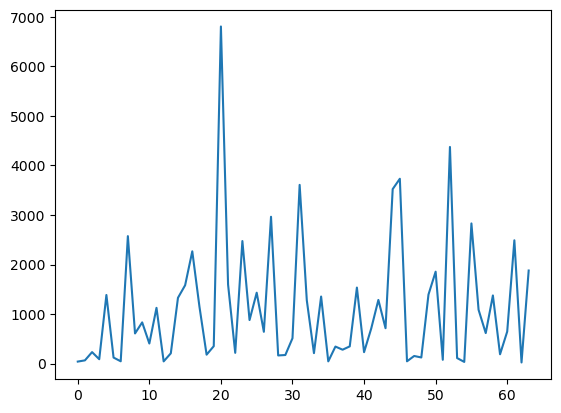

In [26]:
plt.plot(KLenco)
plt.show()

In [27]:
#KLencoMean = numpy.mean(KLenco, axis=0) # in kl_gaussian wird schon mean genommen

In [28]:
#plt.plot(KLencoMean)
#plt.show()

In [29]:
numZero = (numpy.histogram(KLenco, bins=(-0.5, 0.01))[0])/2 #/2 da logvar & mean
print(numZero)

[0.]


In [31]:
Nonzero = latentDim-numZero
print(Nonzero)

[64.]
